# Object Detection with PyTorch

This workshop demonstrates how to build a simple object detection system using PyTorch that can:
- Detect a single object in an image
- Classify the object type (circle or rectangle)
- Locate the object's position (x, y coordinates)

```
Praisan Padungweang

2024, College of Computing, KKU
```

## Common Issues and Tips

1. **Data Normalization**:
   - All position and size values are normalized to [0,1]
   - Must denormalize for visualization
   - Helps with training stability

2. **Model Capacity**:
   - Current architecture is intentionally simple
   - Can be extended with more layers for complex scenes

3. **Performance Metrics**:
   - MSE loss combines classification and regression
   - Consider separate metrics for position vs. classification accuracy

## Prepare Dataset
- Create custom dataset class for handle coco format annotation from label studio.

In [ ]:
# Dowload the dataset and unzip it
!gdown 1sVTk0Wnrkoq-FN1USoMdfEJFI6LxYfHi

Downloading...
From: https://drive.google.com/uc?id=1sVTk0Wnrkoq-FN1USoMdfEJFI6LxYfHi
To: /content/dataset_simpleDetection.zip
100% 36.6k/36.6k [00:00<00:00, 44.7MB/s]


In [ ]:
!unzip /content/dataset_simpleDetection

Archive:  /content/dataset_simpleDetection.zip
replace train/images/055cf90b-image_87.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train/images/055cf90b-image_87.png  
  inflating: train/images/06fd5261-image_68.png  
  inflating: train/images/08c92a46-image_36.png  
  inflating: train/images/0c392bac-image_76.png  
  inflating: train/images/0d193863-image_71.png  
  inflating: train/images/10758b91-image_92.png  
  inflating: train/images/12883919-image_79.png  
  inflating: train/images/15e6e73d-image_88.png  
  inflating: train/images/20a82ac5-image_69.png  
  inflating: train/images/21eba3dd-image_46.png  
  inflating: train/images/23127e28-image_31.png  
  inflating: train/images/313b0477-image_97.png  
  inflating: train/images/348d4481-image_83.png  
  inflating: train/images/3eb430e4-image_66.png  
  inflating: train/images/43e7968b-image_70.png  
  inflating: train/images/45e751cb-image_78.png  
  inflating: train/images/4744b670-image_82.png  
  inflating: train/

In [ ]:
import os
import json
import random
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torch
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# Create dataset class for handle coco annoation format

class SyntheticDectectionDataset(Dataset):
  def __init__(self, images_path, annotations_file, transform=None):
    self.coco = COCO(annotations_file)
    self.images_path = images_path
    self.image_ids = list(self.coco.imgs.keys())
    self.transform = transform

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    image_info = self.coco.imgs[image_id]
    image_path = os.path.join(self.images_path, image_info['file_name']).replace("\\", "/")

    image = Image.open(image_path).convert('L')
    image = np.array(image, dtype=np.float32) / 255.0

    anns_ids = self.coco.getAnnIds(imgIds=image_id)
    anns = self.coco.loadAnns(anns_ids)

    bboxes = [ann['bbox'] for ann in anns]
    labels = [ann['category_id'] for ann in anns]

    bboxes = np.array(bboxes, dtype=np.float32)
    bboxes[:, 0] /= image_info['width']
    bboxes[:, 1] /= image_info['height']
    bboxes[:, 2] /= image_info['width']
    bboxes[:, 3] /= image_info['height']

    bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {'bboxes': bboxes,
              'labels': labels,}

    if self.transform:
      image = self.transform(image)

    return image, target

In [ ]:
# Set paths
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/val"

train_anns = "/content/train.json"
test_anns = "/content/test.json"
val_anns = "/content/val.json"

train_transform = transforms.Compose([
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()])

val_transform = transforms.Compose([
    transforms.ToTensor()])

In [ ]:
# Create datasets
train_dataset = SyntheticDectectionDataset(train_dir, train_anns, train_transform)
test_dataset = SyntheticDectectionDataset(test_dir, test_anns, test_transform)
val_dataset = SyntheticDectectionDataset(val_dir, val_anns, val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


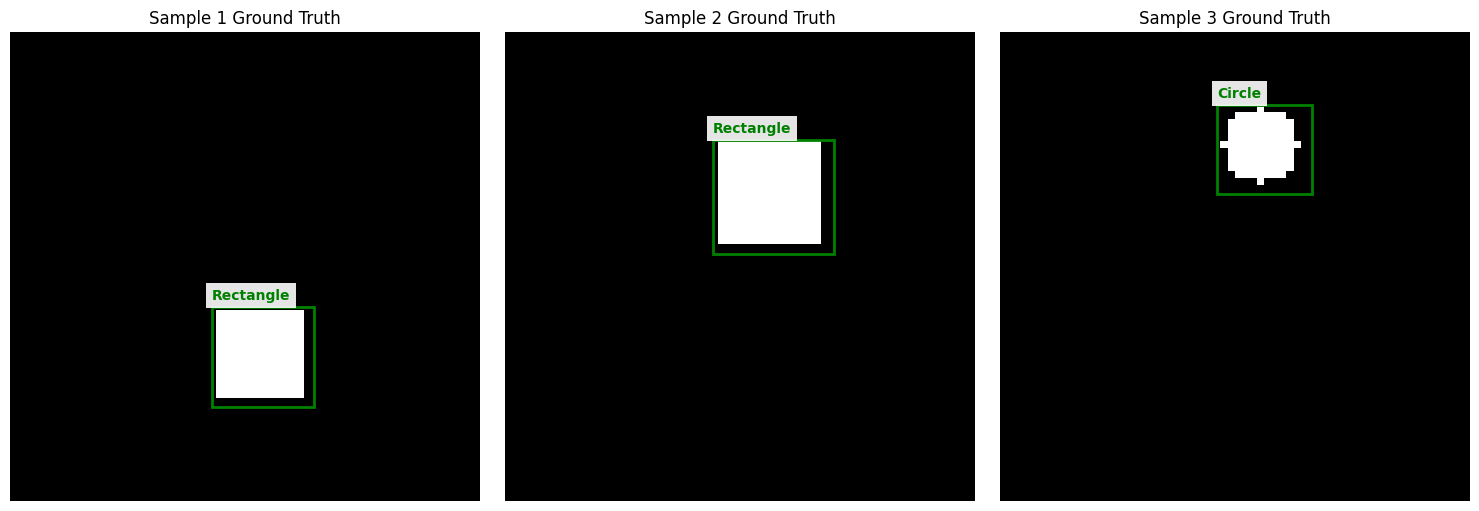

In [ ]:
def plot_samples_from_dataloader(dataloader, num_samples=1):
    images, targets = next(iter(dataloader))
    num_samples = min(num_samples, len(images))

    fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 5))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        image = images[i].numpy().squeeze()
        gt_bboxes = targets['bboxes'][i].numpy()
        labels = targets['labels'][i].numpy()

        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Sample {i + 1} Ground Truth")

        # Plot the bounding boxes
        for bbox, label in zip(gt_bboxes, labels):
            x, y, w, h = bbox *64
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
            axes[i].add_patch(rect)

            label_text = "Circle" if label == 0 else "Rectangle"
            axes[i].text(x, y - 1, label_text, color='g', fontsize=10, weight='bold',
                 bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_samples_from_dataloader(train_loader, num_samples=3)

## Model Architecture
The CNN architecture consists of:

1. **Convolutional Layers**:
   - First conv layer: 1→32 channels, 3x3 kernel
   - Second conv layer: 32→64 channels, 3x3 kernel
   - Each followed by ReLU activation and 2x2 max pooling

2. **Fully Connected Layers**:
   - First FC layer: 64×16×16 → 128 neurons
   - Output layer: 128 → 5 outputs (class, x, y, w, h)

Input image processing:
- Input: 64×64×1 (grayscale)
- After conv1+pool: 32×32×32
- After conv2+pool: 16×16×64
- Flattened: 16,384 features
- Final output: 5 values

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Create a CNN model for object detection

class SimpleObjectDetector(nn.Module):
  def __init__(self):
        super(SimpleObjectDetector, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 16 * 64, 128)
        self.fc2 = nn.Linear(128, 5) # class, x, y, w, h

  def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = nn.Flatten()(x)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x

In [ ]:
!pip install torchview

In [ ]:
from torchview import draw_graph
from torchsummary import summary

In [ ]:
model = SimpleObjectDetector()
model = model.to(device)
summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Linear-5                  [-1, 128]       2,097,280
            Linear-6                    [-1, 5]             645
Total params: 2,116,741
Trainable params: 2,116,741
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.88
Params size (MB): 8.07
Estimated Total Size (MB): 9.97
----------------------------------------------------------------


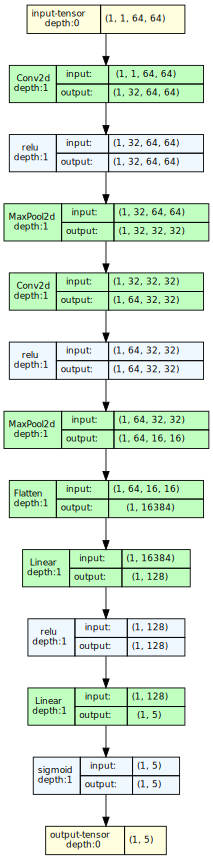

In [ ]:
draw_graph(model, input_size=(1, 1, 64, 64)).visual_graph

## Model Training

The training setup uses:
- Loss function: Mean Squared Error (MSE)
- Optimizer: Adam

The loss function combines:
- Classification error for shape type
- Regression error for position and size

In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}

In [ ]:
# Create train function with collect loss history

def train_model(model, dataloaders, criterion, optimizer, num_epochs, weights_name='weight_save.pth'):

    model = model.to(device)
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            data_loader = dataloaders[phase]

            with tqdm(total=len(data_loader), desc=f"{phase.capitalize()} Epoch {epoch + 1}") as pbar:
                for images, targets in data_loader:
                    images = images.to(device)
                    targets = {k: v.to(device) for k, v in targets.items()}

                    target_bboxes = targets['bboxes'].view(-1, 4)  # (N, 4)
                    target_classes = targets['labels'].view(-1, 1)  # (N, 1)
                    target_combined = torch.cat([target_classes, target_bboxes], dim=1)  # (N, 5)

                    if phase == 'train':
                        optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(images)
                        loss = criterion(outputs, target_combined)

                        # Backward
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * images.size(0)
                    pbar.update(1)

            epoch_loss = running_loss / len(data_loader.dataset)
            history[f"{phase}_loss"].append(epoch_loss)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}")

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), weights_name)
                best_model = model
                print(f"Saved Best Model Weights: {weights_name}")

    return best_model, history

In [ ]:
# Create test function for predict test_loader
def test_model(model, test_loader):
    model.eval()
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = {k: v.to(device) for k, v in targets.items()}

            target_bboxes = targets['bboxes'].view(-1, 4)
            target_classes = targets['labels'].view(-1, 1)
            target_combined = torch.cat([target_classes, target_bboxes], dim=1)

            outputs = model(images)

            predictions.append(outputs.cpu().numpy())
            ground_truths.append(target_combined.cpu().numpy())

    predictions = np.concatenate(predictions)
    ground_truths = np.concatenate(ground_truths)
    return predictions, ground_truths

In [ ]:
# Set dataloader
dataloaders = {'train': train_loader, 'val': val_loader}

# Training setting
model = SimpleObjectDetector()
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-8)
epochs = 10

In [ ]:
# Training Model
best_model, train_history = train_model(model, dataloaders, criterion, optimizer, epochs, 'SimpleObjectDetector.pth')

Epoch 1/10
------------------------------


Train Epoch 1: 100%|██████████| 18/18 [00:01<00:00, 12.40it/s]


Train Loss: 0.0730


Val Epoch 1: 100%|██████████| 4/4 [00:00<00:00, 46.71it/s]


Val Loss: 0.0680
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 2/10
------------------------------


Train Epoch 2: 100%|██████████| 18/18 [00:01<00:00, 12.35it/s]


Train Loss: 0.0595


Val Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 46.74it/s]


Val Loss: 0.0613
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 3/10
------------------------------


Train Epoch 3: 100%|██████████| 18/18 [00:03<00:00,  5.65it/s]


Train Loss: 0.0537


Val Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 21.01it/s]


Val Loss: 0.0548
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 4/10
------------------------------


Train Epoch 4: 100%|██████████| 18/18 [00:02<00:00,  6.23it/s]


Train Loss: 0.0477


Val Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 41.57it/s]


Val Loss: 0.0478
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 5/10
------------------------------


Train Epoch 5: 100%|██████████| 18/18 [00:02<00:00,  8.87it/s]


Train Loss: 0.0437


Val Epoch 5: 100%|██████████| 4/4 [00:00<00:00, 45.80it/s]


Val Loss: 0.0438
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 6/10
------------------------------


Train Epoch 6: 100%|██████████| 18/18 [00:01<00:00, 12.38it/s]


Train Loss: 0.0401


Val Epoch 6: 100%|██████████| 4/4 [00:00<00:00, 63.88it/s]


Val Loss: 0.0389
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 7/10
------------------------------


Train Epoch 7: 100%|██████████| 18/18 [00:01<00:00, 16.75it/s]


Train Loss: 0.0359


Val Epoch 7: 100%|██████████| 4/4 [00:00<00:00, 75.42it/s]


Val Loss: 0.0353
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 8/10
------------------------------


Train Epoch 8: 100%|██████████| 18/18 [00:01<00:00, 16.30it/s]


Train Loss: 0.0332


Val Epoch 8: 100%|██████████| 4/4 [00:00<00:00, 76.79it/s]


Val Loss: 0.0323
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 9/10
------------------------------


Train Epoch 9: 100%|██████████| 18/18 [00:01<00:00, 16.34it/s]


Train Loss: 0.0308


Val Epoch 9: 100%|██████████| 4/4 [00:00<00:00, 74.34it/s]


Val Loss: 0.0293
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 10/10
------------------------------


Train Epoch 10: 100%|██████████| 18/18 [00:01<00:00, 16.13it/s]


Train Loss: 0.0288


Val Epoch 10: 100%|██████████| 4/4 [00:00<00:00, 73.03it/s]


Val Loss: 0.0272
Saved Best Model Weights: SimpleObjectDetector.pth


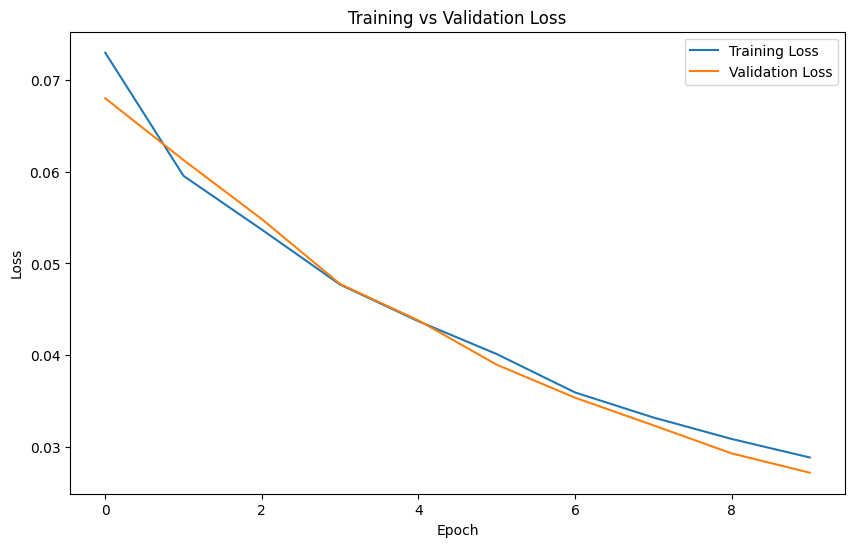

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_history['train_loss'], label='Training Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

plt.legend()
plt.show()

## Model Evaluation
- Calculate the model performance using IoU, Precision, Recall and F1-Score

In [ ]:
# IoU function to compute intersection over union
def compute_iou(pred_bbox, gt_bbox):
    # Calculate intersection coordinates
    x1 = max(pred_bbox[0], gt_bbox[0])
    y1 = max(pred_bbox[1], gt_bbox[1])
    x2 = min(pred_bbox[0] + pred_bbox[2], gt_bbox[0] + gt_bbox[2])
    y2 = min(pred_bbox[1] + pred_bbox[3], gt_bbox[1] + gt_bbox[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate union area
    pred_area = pred_bbox[2] * pred_bbox[3]
    gt_area = gt_bbox[2] * gt_bbox[3]
    union_area = pred_area + gt_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0.0
    return iou


def calculate_performance(predictions, ground_truths, iou_threshold=0.5):
    TP = 0
    FP = 0
    FN = 0
    iou_values = []

    for pred, gt in zip(predictions, ground_truths):
        iou = compute_iou(pred[1:], gt[1:])
        iou_values.append(iou)

        if iou >= iou_threshold and np.argmax(pred[:1]) == np.argmax(gt[:1]):
            TP +=1
        elif iou < iou_threshold and np.argmax(pred[:1]) == np.argmax(gt[:1]):
            FN +=1
        elif iou >= iou_threshold and np.argmax(pred[:1]) != np.argmax(gt[:1]):
            FP += 1

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    mean_iou = np.mean(iou_values)

    return precision, recall, f1_score, mean_iou

In [ ]:
predictions, ground_truths = test_model(model, test_loader)

precision, recall, f1_score, mean_iou = calculate_performance(predictions, ground_truths)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")

Precision: 1.0000
Recall: 0.7333
F1-Score: 0.8462
Mean IoU: 0.5470


## Visualization Outcome
- Visualize the model's predictions by comparing the bounding boxes of the ground truth labels and the model's predictions. Display the images with both sets of bounding boxes overlaid and analyze the performance.

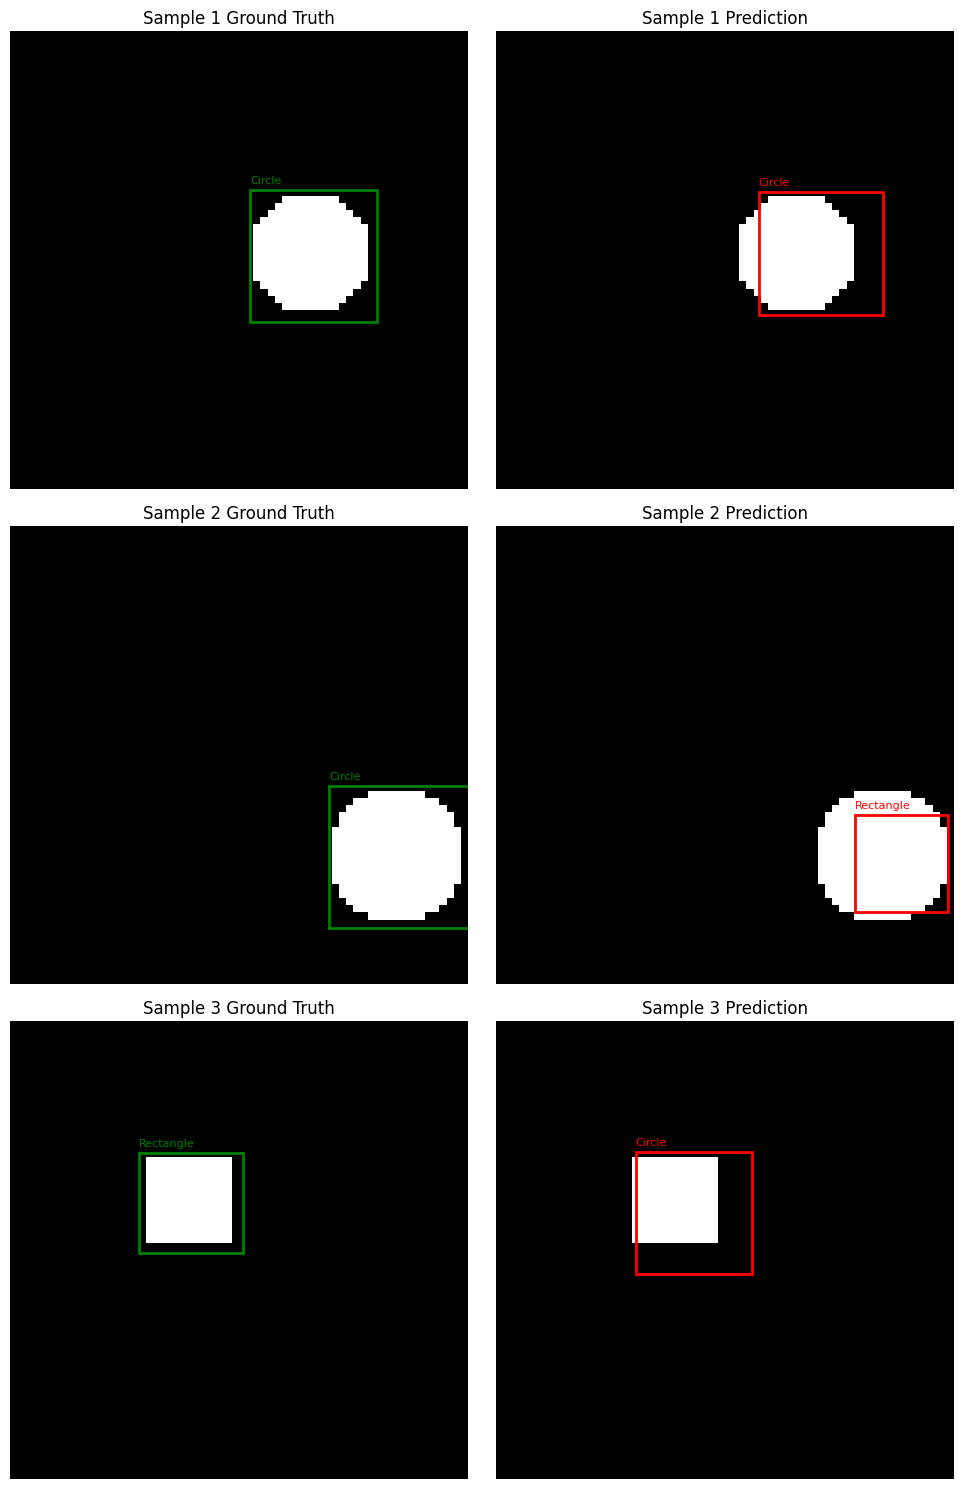

In [ ]:
def visualize_predictions(model, test_loader, num_samples=3):
    model.eval()
    images_so_far = 0
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = {k: v.to(device) for k, v in targets.items()}
            outputs = model(images)

            for i in range(images.size(0)):
                if images_so_far >= num_samples:
                    break

                image = images[i].cpu().numpy().squeeze()
                gt_bboxes = targets['bboxes'][i].cpu().numpy()
                gt_labels = targets['labels'][i].cpu().numpy()
                pred_bbox = outputs[i, 1:].cpu().detach().numpy()
                pred_class = outputs[i, 0].cpu().detach().numpy()

                # Denormalize bounding boxes
                gt_bboxes = gt_bboxes * 64
                pred_bbox = pred_bbox * 64

                ax_gt = axes[images_so_far, 0]
                ax_pred = axes[images_so_far, 1]

                # Plot ground truth
                ax_gt.imshow(image, cmap='gray')
                ax_gt.set_title(f"Sample {images_so_far + 1} Ground Truth")
                for bbox, label in zip(gt_bboxes, gt_labels):
                    x, y, w, h = bbox
                    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
                    ax_gt.add_patch(rect)
                    label_text = "Circle" if label == 0 else "Rectangle"
                    ax_gt.text(x, y - 1, label_text, color='g', fontsize=8)
                ax_gt.axis('off')

                # Plot predictions
                ax_pred.imshow(image, cmap='gray')
                ax_pred.set_title(f"Sample {images_so_far + 1} Prediction")
                x, y, w, h = pred_bbox
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                ax_pred.add_patch(rect)
                label_text = "Circle" if pred_class < 0.5 else "Rectangle"
                ax_pred.text(x, y - 1, label_text, color='r', fontsize=8)
                ax_pred.axis('off')

                images_so_far += 1

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)